<a href="https://colab.research.google.com/github/Eugenechee51/HybridAI-course/blob/main/lab1/cs_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовка датасета

In [1]:
import pandas as pd

df = pd.read_csv('csgo_round_snapshots.csv')
# df = df[df.map == 'de_dust2']

# Отбрасываем игровые карты
df = df.drop(columns = 'map')

# Удаляем данные о вооружении 
df = df.drop(df.iloc[:, 15:95], axis = 1)

df['bomb_planted'] = df['bomb_planted'].astype(int)

# Отделяем отклики
y = df['round_winner']
target_names = {'T': 0, 'CT': 1}
# Маппим лейблы
y = y.map(target_names).astype(int)

# Удаляем отклики из Х
X = df.drop(columns = 'round_winner')

# X = df.drop(df.iloc[:, 15:96], axis = 1)

feature_names = X.columns.values.tolist()

df.head(5)

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,round_winner
0,175.00,0.0,0.0,0,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,CT
1,156.03,0.0,0.0,0,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,CT
2,96.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT
3,76.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT
4,174.97,1.0,0.0,0,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,CT


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 101)

##Обучение дерева решений

In [3]:
from sklearn.tree import DecisionTreeClassifier

max_depth = 4
model = DecisionTreeClassifier(max_depth = max_depth)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

pred = model.predict(X_test)
print(f1_score(pred, y_test))
print(accuracy_score(y_test, pred))

0.7527678037103531
0.7300057184870518


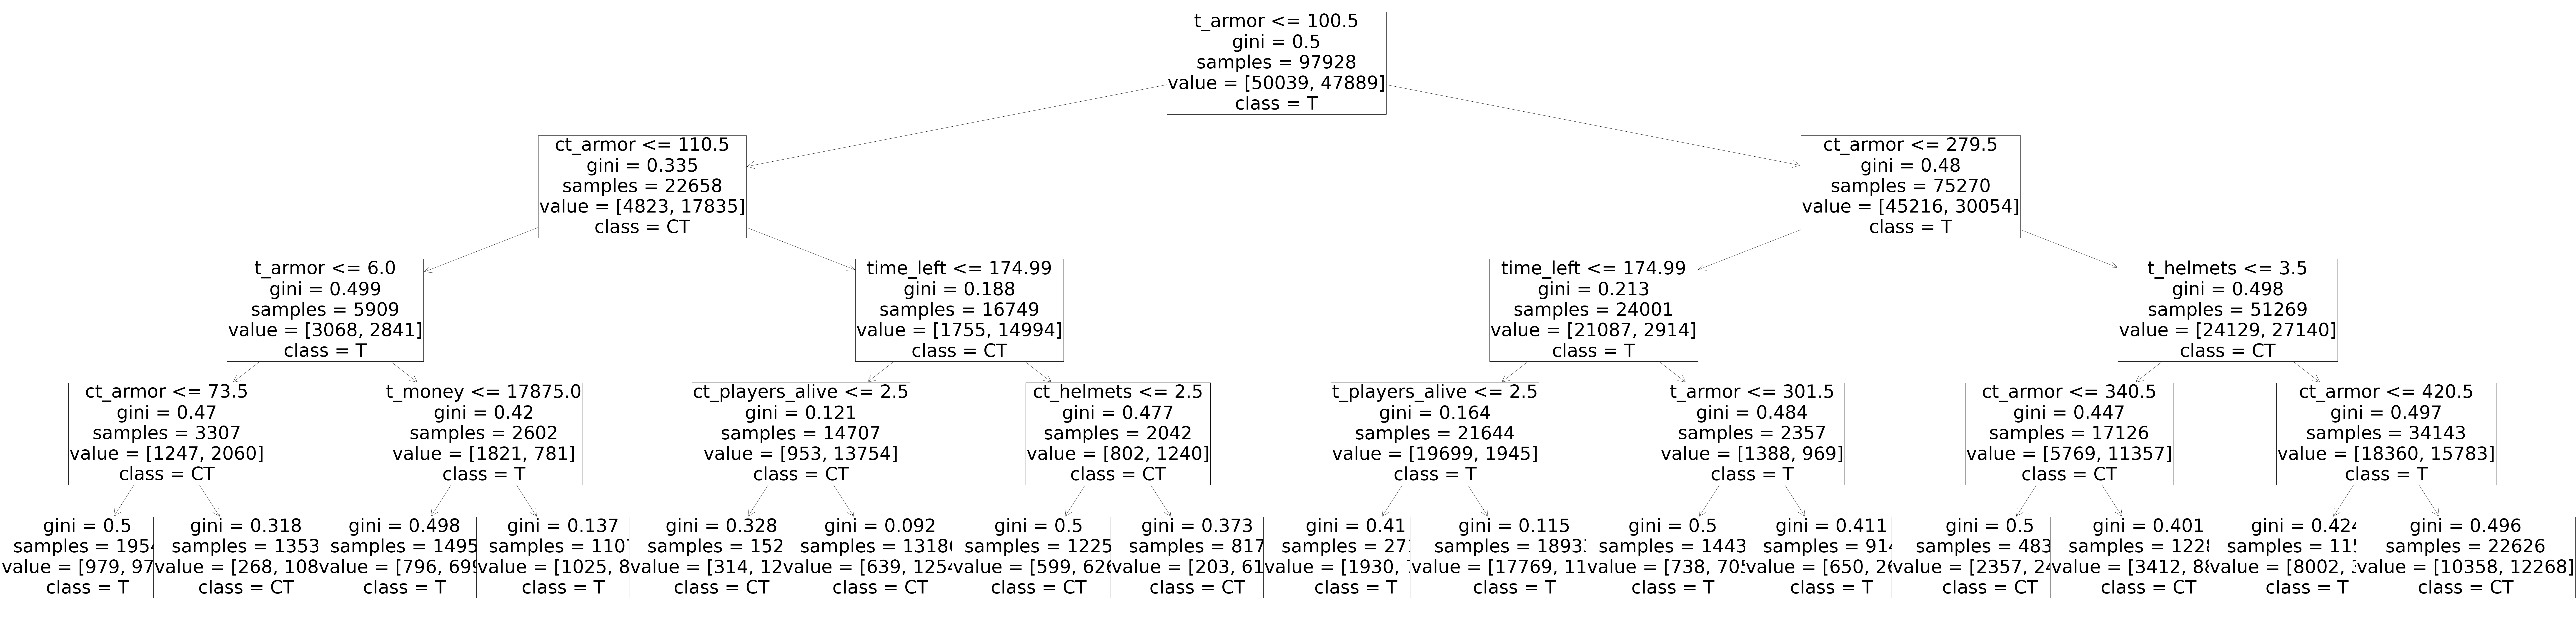

In [5]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(200, 50))
tree.plot_tree(model,
               feature_names = feature_names,
               class_names = ['T', 'CT'],
               fontsize=80)
fig.savefig('tree.png')
fig.show()

In [6]:
from joblib import dump

dump(model, 'tree.joblib')

['tree.joblib']

## Ручное составление правил (глубина 3)

In [7]:
!pip install pydatalog
from pyDatalog import pyDatalog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# tree in Datalog
pyDatalog.create_terms('U, V, label, t_armor, ct_armor, time_left, t_helmets')

(label[U] == 'CT') <= (ct_armor[U] <= 110.5) & (t_armor[U] <= 6.0) 
(label[U] == 'T') <= (t_armor[U] <= 100.5) & (ct_armor[U] <= 110.5) & (t_armor[U] > 6.0) 
(label[U] == 'CT') <= (t_armor[U] <= 100.5) & (ct_armor[U] > 110.5)
(label[U] == 'T') <= (t_armor[U] > 100.5) & (ct_armor[U] <= 279.5)
(label[U] == 'CT') <= (t_armor[U] > 100.5) & (ct_armor[U] > 279.5) & (t_helmets[U] <= 3.5) 
(label[U] == 'T') <= (t_armor[U] > 100.5) & (ct_armor[U] > 279.5) & (t_helmets[U] > 3.5)

label[1]==(*,U,'T') <= t_armor[1]>(*,U,'100.5')&ct

##Тесты ручного составления

In [9]:
# Adding facts

# Test 0 (CT)
t_armor[0] = 1
ct_armor[0] = 50.5
print(label[0] == U, end='\n\n')

# Test 1 (T)
t_armor[1] = 10
ct_armor[1] = 70
print(label[1] == U, end='\n\n')

# Test 2 (CT)
t_armor[2] = 20
ct_armor[2] = 300
print(label[2] == U, end='\n\n')

# Test 3 (T)
t_armor[3] = 500
ct_armor[3] = 200
print(label[3] == U, end='\n\n')

# Test 4 (CT)
t_armor[4] = 300
ct_armor[4] = 280
t_helmets[4] = 3
print(label[4] == U, end='\n\n')

# Test 5 (T)
t_armor[5] = 300
ct_armor[5] = 280
t_helmets[5] = 5
print(label[5] == U)

U 
--
CT

U
-
T

U 
--
CT

U
-
T

U 
--
CT

U
-
T


#Динамическое составление выражений

##Извлечение правил из дерева

In [10]:
from joblib import load
import sklearn

model = load('tree.joblib')
classes = model.classes_
tree = model.tree_

n_nodes = tree.node_count
children_left = tree.children_left
children_right = tree.children_right
feature = tree.feature
threshold = tree.threshold
value = tree.value

In [11]:
# Создаем список фич в том порядке, в котором они встречаются в дереве
feature_name = [feature_names[i] 
                if i != -2 else 'leaf'
                for i in feature]

In [12]:
import numpy as np
from sklearn.tree import _tree
import copy

flag = False

def recurse_collect(node, depth, rule, rules):
  global degen_flag
  indent = "    " * depth
  if  feature[node] != _tree.TREE_UNDEFINED:
      name = feature_name[node]
      thresh = round(threshold[node], 2)
      rule['conjuncts'].append({'feature': feature[node], 'threshold': thresh, 'comparison': '<='})
      print(f"{indent} {name} <= {thresh}")

      recurse_collect(children_left[node], depth + 1, rule, rules)
      left_label = rule['label']
      rule['conjuncts'] = rule['conjuncts'][0 : len(rule['conjuncts']) - 1]
      rule['conjuncts'].append({'feature': feature[node], 'threshold': thresh, 'comparison': '>'})
      print(f"{indent} {name} > {thresh}")

      recurse_collect(children_right[node], depth + 1, rule, rules)
      right_label = rule['label']

      # Удаляем вырожденные деревья
      if left_label == right_label and left_label != -1 and right_label != -1:
          #print(f'{left_label} {right_label}')
          if degen_flag:
            print('Double degenerate: '+ f'{left_label} {right_label}')
            rules.pop()
            rules[-1]['conjuncts'].pop()
          rules.pop()
          rules[-1]['conjuncts'].pop()
          degen_flag = True
      else: 
        degen_flag = False
      rule['label'] = -1
      rule['conjuncts'] = rule['conjuncts'][0 : len(rule['conjuncts']) - 1]
      
  else:
      print(f"{indent} {np.argmax(value[node])}")
      rule['label'] = np.argmax(value[node])
      rules.append(copy.copy(rule))

  return rules

In [13]:
flag = False
rules = recurse_collect(0, 0, {'label': int, 'conjuncts': []}, rules=[])

rules

 t_armor <= 100.5
     ct_armor <= 110.5
         t_armor <= 6.0
             ct_armor <= 73.5
                 0
             ct_armor > 73.5
                 1
         t_armor > 6.0
             t_money <= 17875.0
                 0
             t_money > 17875.0
                 0
     ct_armor > 110.5
         time_left <= 174.99
             ct_players_alive <= 2.5
                 1
             ct_players_alive > 2.5
                 1
         time_left > 174.99
             ct_helmets <= 2.5
                 1
             ct_helmets > 2.5
                 1
Double degenerate: 1 1
 t_armor > 100.5
     ct_armor <= 279.5
         time_left <= 174.99
             t_players_alive <= 2.5
                 0
             t_players_alive > 2.5
                 0
         time_left > 174.99
             t_armor <= 301.5
                 0
             t_armor > 301.5
                 0
Double degenerate: 0 0
     ct_armor > 279.5
         t_helmets <= 3.5
             ct_armor <= 340

[{'label': 0,
  'conjuncts': [{'feature': 7, 'threshold': 100.5, 'comparison': '<='},
   {'feature': 6, 'threshold': 110.5, 'comparison': '<='},
   {'feature': 7, 'threshold': 6.0, 'comparison': '<='},
   {'feature': 6, 'threshold': 73.5, 'comparison': '<='}]},
 {'label': 1,
  'conjuncts': [{'feature': 7, 'threshold': 100.5, 'comparison': '<='},
   {'feature': 6, 'threshold': 110.5, 'comparison': '<='},
   {'feature': 7, 'threshold': 6.0, 'comparison': '<='},
   {'feature': 6, 'threshold': 73.5, 'comparison': '>'}]},
 {'label': 0,
  'conjuncts': [{'feature': 7, 'threshold': 100.5, 'comparison': '<='},
   {'feature': 6, 'threshold': 110.5, 'comparison': '<='},
   {'feature': 7, 'threshold': 6.0, 'comparison': '>'}]},
 {'label': 1,
  'conjuncts': [{'feature': 7, 'threshold': 100.5, 'comparison': '<='},
   {'feature': 6, 'threshold': 110.5, 'comparison': '>'}]},
 {'label': 0,
  'conjuncts': [{'feature': 7, 'threshold': 100.5, 'comparison': '>'},
   {'feature': 6, 'threshold': 279.5, 'comp

## Удаление бессмысленных правил

In [14]:
def clean_useless(rules):
  for d in rules:
    feature_indices = []
    for dic in d['conjuncts']:
      feature_indices.append(dic['feature'])

    dup = {x for x in feature_indices if feature_indices.count(x) > 1}
    fix = []
    dup = list(dup)
    print(dup)
    for i in dup:
      fix = []
      for dic in d['conjuncts']:
        if dic['feature'] == i:
          fix.append(dic)
      print(fix)

      if (fix[0]['comparison'] == fix[1]['comparison']) and fix[0]['comparison'] == '<=':
        print('case 1')
        number = max(fix[0]['threshold'], fix[1]['threshold'])
        for n in range(len(d['conjuncts'])):
          if d['conjuncts'][n - 1]['feature'] == i and d['conjuncts'][n - 1]['threshold'] == number:
            d['conjuncts'].pop(n - 1)

      elif (fix[0]['comparison'] == fix[1]['comparison']) and fix[0]['comparison'] == '>':
        print('case 2')
        number = min(fix[0]['threshold'], fix[1]['threshold'])
        for n in range(len(d['conjuncts'])):
          if d['conjuncts'][n - 1]['feature'] == i and d['conjuncts'][n - 1]['threshold'] == number:
            d['conjuncts'].pop(n - 1)

    print(d['conjuncts'])
    print()

clean_useless(rules)

[6, 7]
[{'feature': 6, 'threshold': 110.5, 'comparison': '<='}, {'feature': 6, 'threshold': 73.5, 'comparison': '<='}]
case 1
[{'feature': 7, 'threshold': 100.5, 'comparison': '<='}, {'feature': 7, 'threshold': 6.0, 'comparison': '<='}]
case 1
[{'feature': 7, 'threshold': 6.0, 'comparison': '<='}, {'feature': 6, 'threshold': 73.5, 'comparison': '<='}]

[6, 7]
[{'feature': 6, 'threshold': 110.5, 'comparison': '<='}, {'feature': 6, 'threshold': 73.5, 'comparison': '>'}]
[{'feature': 7, 'threshold': 100.5, 'comparison': '<='}, {'feature': 7, 'threshold': 6.0, 'comparison': '<='}]
case 1
[{'feature': 6, 'threshold': 110.5, 'comparison': '<='}, {'feature': 7, 'threshold': 6.0, 'comparison': '<='}, {'feature': 6, 'threshold': 73.5, 'comparison': '>'}]

[7]
[{'feature': 7, 'threshold': 100.5, 'comparison': '<='}, {'feature': 7, 'threshold': 6.0, 'comparison': '>'}]
[{'feature': 7, 'threshold': 100.5, 'comparison': '<='}, {'feature': 6, 'threshold': 110.5, 'comparison': '<='}, {'feature': 7, '

## Обход дерева с лекции



In [15]:
# # Collecting tree pathes
# def get_paths(paths):
#   for path in paths:
#     left = children_left[path[-1]]
#     right = children_right[path[-1]]
#     if left != right:
#       paths.remove(path)
#       paths.append(path + [left])
#       paths.append(path + [right])
#       #paths.append([right])
#       get_paths(paths)
#   return paths

# paths = [[0]]
# paths = get_paths(paths)
# paths

In [16]:
# rules = []
# unique_features = set()

# for path in paths:
#   # составляем для каждого пути список конъюнктов 
#   conjuncts = []
#   for i, node in enumerate(path):
#     # если узел == лист
#     if node == path[-1]:
#       samples = list(value[node][0])
#       # наиболее многочисленный класс
#       label = samples.index(max(samples))
#     else:
#       conjunct = {'feature': feature[node],
#                   'threshold': threshold[node]}
#       unique_features.add(feature[node])
#       # следующий узел-ребенок есть всегда
#       child = path[i + 1]
#       if child in children_left:
#         conjunct['comparison'] = '<='
#       else:
#         conjunct['comparison'] = '>'
#       conjuncts.append(conjunct)
#   rules.append({'label': label, 'conjuncts': conjuncts})

# rules

In [17]:
# used_feature_names = set()
# for i in unique_features:
#    used_feature_names.add(feature_names[i])
# used_feature_names

## Constructing rules

In [18]:
def format_name(name):
  name = str(name)
  name = name.replace(' ', '_')
  name = name.replace('(', '')
  name = name.replace(')', '')
  return name
  
feature_names = [format_name(x) for x in feature_names]
class_names = [f"'{x}'" for x in target_names]
print(class_names)

["'T'", "'CT'"]


In [19]:
tmplts = []
# rules - список словарей
for rule in rules:
  label = class_names[rule['label']]
  tmplt_label = f'(label[U] == {label})'
  conjuncts = rule['conjuncts']
  if conjuncts:
    conditions = []
    for conjunct in conjuncts:
      feature_name = feature_names[conjunct['feature']]
      conditions.append(f'({feature_name}[U] {conjunct["comparison"]} {conjunct["threshold"]})')
    tmplt_condition = ' & '.join(conditions)
    # <= оператор импликации в данном случае
    tmplts.append(f'{tmplt_label} <= {tmplt_condition}')
  else:
    tmplts.append(tmplt_label)

tmplts

["(label[U] == 'T') <= (t_armor[U] <= 6.0) & (ct_armor[U] <= 73.5)",
 "(label[U] == 'CT') <= (ct_armor[U] <= 110.5) & (t_armor[U] <= 6.0) & (ct_armor[U] > 73.5)",
 "(label[U] == 'T') <= (t_armor[U] <= 100.5) & (ct_armor[U] <= 110.5) & (t_armor[U] > 6.0)",
 "(label[U] == 'CT') <= (t_armor[U] <= 100.5) & (ct_armor[U] > 110.5)",
 "(label[U] == 'T') <= (t_armor[U] > 100.5) & (ct_armor[U] <= 279.5)",
 "(label[U] == 'CT') <= (t_armor[U] > 100.5) & (ct_armor[U] > 279.5) & (t_helmets[U] <= 3.5)",
 "(label[U] == 'T') <= (t_armor[U] > 100.5) & (ct_armor[U] > 279.5) & (t_helmets[U] > 3.5) & (ct_armor[U] <= 420.5)",
 "(label[U] == 'CT') <= (t_armor[U] > 100.5) & (t_helmets[U] > 3.5) & (ct_armor[U] > 420.5)"]

### Для сравнения список правил без оптимизаций (глубина 4):

```
["(label[U] == 'T') <= (t_armor[U] <= 100.5) & (ct_armor[U] <= 110.5) & (t_armor[U] <= 6.0) & (ct_armor[U] <= 73.5)",
 "(label[U] == 'CT') <= (t_armor[U] <= 100.5) & (ct_armor[U] <= 110.5) & (t_armor[U] <= 6.0) & (ct_armor[U] > 73.5)",
 "(label[U] == 'T') <= (t_armor[U] <= 100.5) & (ct_armor[U] <= 110.5) & (t_armor[U] > 6.0)",
 "(label[U] == 'CT') <= (t_armor[U] <= 100.5) & (ct_armor[U] > 110.5) & (time_left[U] <= 174.99)",
 "(label[U] == 'CT') <= (t_armor[U] <= 100.5) & (ct_armor[U] > 110.5) & (time_left[U] > 174.99)",
 "(label[U] == 'T') <= (t_armor[U] > 100.5) & (ct_armor[U] <= 279.5) & (time_left[U] <= 174.99)",
 "(label[U] == 'T') <= (t_armor[U] > 100.5) & (ct_armor[U] <= 279.5) & (time_left[U] > 174.99)",
 "(label[U] == 'CT') <= (t_armor[U] > 100.5) & (ct_armor[U] > 279.5) & (t_helmets[U] <= 3.5)",
 "(label[U] == 'T') <= (t_armor[U] > 100.5) & (ct_armor[U] > 279.5) & (t_helmets[U] > 3.5) & (ct_armor[U] <= 420.5)",
 "(label[U] == 'CT') <= (t_armor[U] > 100.5) & (ct_armor[U] > 279.5) & (t_helmets[U] > 3.5) & (ct_armor[U] > 420.5)"]
```



##Creating terms

In [20]:
feature_indices = [x for x in set(feature) if x >= 0]
predicates = ', '.join([feature_names[x] for x in feature_indices])

# vars = ""
# for i in range(85, 85 + len(used_feature_names)):
#   vars += chr(i) + ', '

pyDatalog.create_terms('U, V, label, ' + predicates)

In [21]:
# Термы переопределяются в обратном порядке
tmplts.reverse()

knowledge = """\n""".join(tmplts)

pyDatalog.load("""
""" + knowledge + """
""")
print(knowledge)

tmplts.reverse()

(label[U] == 'CT') <= (t_armor[U] > 100.5) & (t_helmets[U] > 3.5) & (ct_armor[U] > 420.5)
(label[U] == 'T') <= (t_armor[U] > 100.5) & (ct_armor[U] > 279.5) & (t_helmets[U] > 3.5) & (ct_armor[U] <= 420.5)
(label[U] == 'CT') <= (t_armor[U] > 100.5) & (ct_armor[U] > 279.5) & (t_helmets[U] <= 3.5)
(label[U] == 'T') <= (t_armor[U] > 100.5) & (ct_armor[U] <= 279.5)
(label[U] == 'CT') <= (t_armor[U] <= 100.5) & (ct_armor[U] > 110.5)
(label[U] == 'T') <= (t_armor[U] <= 100.5) & (ct_armor[U] <= 110.5) & (t_armor[U] > 6.0)
(label[U] == 'CT') <= (ct_armor[U] <= 110.5) & (t_armor[U] <= 6.0) & (ct_armor[U] > 73.5)
(label[U] == 'T') <= (t_armor[U] <= 6.0) & (ct_armor[U] <= 73.5)


## Добавление фактов в базу знаний

In [22]:
n = 10001
row = X.iloc[n]
for i in feature_indices:
  fact = f'{feature_names[i]}[{n}] = {row[i]}'
  print(fact)
  exec(fact)
print(df.iloc[n]['round_winner'])

time_left[10001] = 49.96
ct_armor[10001] = 370.0
t_armor[10001] = 200.0
t_money[10001] = 250.0
ct_helmets[10001] = 3.0
t_helmets[10001] = 2.0
ct_players_alive[10001] = 4.0
t_players_alive[10001] = 2.0
CT


In [23]:
# Запрос
print(pyDatalog.ask('label[U] == V'))

{(2, 'CT'), (5, 'T'), (3, 'T'), (4, 'CT'), (0, 'T'), (10001, 'CT'), (1, 'T')}
